# Incremental Training Setup

This notebook now supports **incremental training** - the model will automatically load existing weights from `augmented_embeddings_model.pth` if it exists, and continue training from there.

## Training Behavior:
- **First run**: Starts with random weights (fresh model)
- **Subsequent runs**: Loads existing weights and continues training
- **Benefits**: Accumulative learning, faster convergence, builds on previous training

## Control Options:
- To **start fresh**: Delete or rename the existing model file before training
- To **continue**: Just run the training cell normally
- To **backup**: Copy the model file before training to preserve previous versions

In [1]:
# Model Management Utilities
import os
import shutil
from datetime import datetime

def check_model_status(model_path):
    """Check if model file exists and display its info."""
    if os.path.exists(model_path):
        file_size = os.path.getsize(model_path) / (1024 * 1024)  # MB
        mod_time = datetime.fromtimestamp(os.path.getmtime(model_path))
        print(f"✓ Model exists: {model_path}")
        print(f"  Size: {file_size:.2f} MB")
        print(f"  Last modified: {mod_time}")
        return True
    else:
        print(f"✗ No model found: {model_path}")
        return False

def backup_model(model_path, backup_suffix=None):
    """Create a backup of the current model."""
    if not os.path.exists(model_path):
        print("No model to backup")
        return None
    
    if backup_suffix is None:
        backup_suffix = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    backup_path = model_path.replace('.pth', f'_backup_{backup_suffix}.pth')
    shutil.copy2(model_path, backup_path)
    print(f"✓ Model backed up to: {backup_path}")
    return backup_path

def reset_model(model_path):
    """Delete the existing model to start fresh training."""
    if os.path.exists(model_path):
        os.remove(model_path)
        print(f"✓ Model deleted: {model_path}")
        print("Next training will start with pre-trained ResNet18 weights")
    else:
        print("No model to delete")

def force_pretrained_training():
    """
    Helper function to train with fresh pre-trained ResNet18 weights.
    Use this when you want to ignore saved weights and start from pre-trained backbone.
    """
    print("🔄 Setting up training with fresh pre-trained ResNet18 weights...")
    
    # Create EmbeddingsProcessor with force_pretrained option
    fresh_processor = EmbeddingsProcessor(
        train_dir=temp_data_dir,
        model_save_path=model_save_path,
        device=device
    )
    
    # Setup model with force_pretrained=True
    fresh_processor.setup_model(SiameseNet, force_pretrained=True)
    
    return fresh_processor

# Check current model status
notebooks_dir = "/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks"
model_save_path = os.path.join(notebooks_dir, "augmented_embeddings_model.pth")

print("Current model status:")
check_model_status(model_save_path)

print("\n📚 Training Options:")
print("1. Normal training: Loads saved weights if available, otherwise uses pre-trained ResNet18")
print("2. Fresh pre-trained: force_pretrained_training() - Ignores saved weights, starts with pre-trained ResNet18")
print("3. Complete reset: reset_model() then train - Deletes saved model, starts with pre-trained ResNet18")

Current model status:
✓ Model exists: /Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks/augmented_embeddings_model.pth
  Size: 43.86 MB
  Last modified: 2025-07-15 23:07:33.236093

📚 Training Options:
1. Normal training: Loads saved weights if available, otherwise uses pre-trained ResNet18
2. Fresh pre-trained: force_pretrained_training() - Ignores saved weights, starts with pre-trained ResNet18
3. Complete reset: reset_model() then train - Deletes saved model, starts with pre-trained ResNet18


In [2]:
import os
import sys

# Add the parent directory to the path to import modules
sys.path.append('/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI')

from modules.det_processor import DetectionProcessor
from modules.detection import DetectionModel
from modules.tracker import AffineAwareByteTrack
from tools.store_driver import Store
import torch


# Initialize required components
store = Store()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
detection_model = DetectionModel(store=store, device=device)
tracker = AffineAwareByteTrack()

# Create detection processor
detection_processor = DetectionProcessor(
    model=detection_model,
    tracker=tracker,
    detection_file_path=""  # Not needed for loading
)

# Load multi_frame_detections from tracks.json
tracks_json_path = "/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks/tracks.json"
video_source = "/Users/fernandomousinho/Library/CloudStorage/GoogleDrive-fmousinho76@gmail.com/My Drive/Colab_Notebooks/FCA_Upstate_NY_003.mp4"

multi_frame_detections = detection_processor.json_to_detections(
    json_file_path=tracks_json_path,
    update_tracker_state=True,
    video_source=video_source
)



ImportError: cannot import name 'augment_images_with_config' from 'modules.augmentation' (/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/modules/augmentation.py)

In [ ]:
from PIL import Image
tracks_data = tracker.get_tracks_data()


In [ ]:
from modules.augmentation import augment_images, test_augmentation

# Test the augmentation function
print("Testing augmentation function from modules.augmentation...")
test_results = test_augmentation()
print(f"✓ Augmentation module imported and tested successfully!")

Testing augmentation function from modules.augmentation...
Test augmentation: 1 image -> 21 augmented images
✓ Augmentation module imported and tested successfully!


In [ ]:
import numpy as np

frame_id_sample = [300, 600, 900]
track_ids_for_frame = {}

# Initialize the dictionary with empty lists for each frame
for frame_id in frame_id_sample:
    track_ids_for_frame[frame_id] = []


for detections in multi_frame_detections:
    frame_id = detections.metadata['frame_id']
    if frame_id in frame_id_sample:
        # Handle class_id using numpy operations
        mask = detections.class_id == 3
        track_ids_for_frame[frame_id] = detections.tracker_id[mask]
       
for frame_id in frame_id_sample:
    print(f"Frame {frame_id}: Track IDs {track_ids_for_frame[frame_id]}")

NameError: name 'multi_frame_detections' is not defined

In [ ]:
import supervision as sv
from modules.dataset import LacrossePlayerDataset
from config.transforms import get_transforms, initialize_background_removal, refresh_transform_instances
from config.all_config import transform_config
video_info = sv.VideoInfo.from_video_path(video_source)
transform_config.enable_background_removal = True
stride = video_info.total_frames // transform_config.background_detector_sample_frames
video_info = sv.VideoInfo.from_video_path(video_path=video_source)
generator_params = {
    "source_path": video_source,
    "end": 1200
}
grass_crop_generator = sv.get_video_frames_generator(**generator_params, stride=stride )        
sample_images = [frame for frame in grass_crop_generator]
initialize_background_removal(sample_images)
refresh_transform_instances()

In [ ]:

list_of_annotated_crops_dict = []
for frame_id in frame_id_sample:
    track_ids_to_process = track_ids_for_frame[frame_id]
    track_data_to_process = [data for data in tracks_data.values() if data.track_id in track_ids_to_process]
    augmented_crops_dict = {}
    for data in track_data_to_process:
        original_crops = data.crops[:5]
        augmented_crops = augment_images(original_crops)
        augmented_crops_dict[data.track_id] = augmented_crops
    list_of_annotated_crops_dict.append(augmented_crops_dict.copy())



In [ ]:
from modules.dataset import LacrossePlayerDataset
from config.transforms import get_transforms
import tempfile
import os
import cv2

def create_augmented_dataset(
    augmented_crops_dict,
    transforms_config='opencv_safe_training',
    temp_dir_prefix="augmented_data",
    verbose=True
):
    """
    Create a LacrossePlayerDataset from augmented crops dictionary.
    
    Args:
        augmented_crops_dict: Dictionary of {track_id: [augmented_crops]}
        transforms_config: Transform configuration to use (default: 'opencv_safe_training')
        temp_dir_prefix: Prefix for the temporary directory name
        verbose: If True, print detailed information
    
    Returns:
        tuple: (dataset, temp_data_dir, total_images_saved)
            - dataset: The created LacrossePlayerDataset
            - temp_data_dir: Path to the temporary data directory
            - total_images_saved: Number of images successfully saved
    """
    
    # Create a temporary directory structure for the dataset
    temp_dir = tempfile.mkdtemp()
    data_dir = os.path.join(temp_dir, temp_dir_prefix)
    os.makedirs(data_dir, exist_ok=True)

    if verbose:
        print(f"Creating dataset in temporary directory: {data_dir}")

    # Create subdirectories for each track (treating each track as a class)
    track_dirs = {}
    for track_id in augmented_crops_dict.keys():
        track_dir = os.path.join(data_dir, f"track_{track_id}")
        os.makedirs(track_dir, exist_ok=True)
        track_dirs[track_id] = track_dir

    # Save augmented crops as image files
    total_images_saved = 0
    failed_saves = 0

    for track_id, augmented_crops in augmented_crops_dict.items():
        track_dir = track_dirs[track_id]
        
        for idx, crop in enumerate(augmented_crops):
            if crop is not None and crop.size > 0:
                # Save as PNG file
                image_path = os.path.join(track_dir, f"crop_{idx:04d}.png")
                success = cv2.imwrite(image_path, crop)
                if success:
                    total_images_saved += 1
                else:
                    failed_saves += 1
                    if verbose:
                        print(f"Failed to save image: {image_path}")

    if verbose:
        print(f"Saved {total_images_saved} augmented images across {len(track_dirs)} track directories")
        if failed_saves > 0:
            print(f"Warning: {failed_saves} images failed to save")

    # Create the LacrossePlayerDataset
    transforms = get_transforms(transforms_config)

    # Create dataset
    augmented_dataset = LacrossePlayerDataset(
        data_dir,
        transform=transforms
    )

    if verbose:
        print(f"Created LacrossePlayerDataset with {len(augmented_dataset)} samples")
        print(f"Temporary data directory: {data_dir}")
        print("Note: This directory can be cleaned up later with: import shutil; shutil.rmtree(temp_data_dir)")

    return augmented_dataset, data_dir, total_images_saved

def cleanup_temp_directory(temp_data_dir, verbose=True):
    """
    Clean up the temporary directory created for the dataset.
    
    Args:
        temp_data_dir: Path to the temporary directory to clean up
        verbose: If True, print cleanup information
    """
    import shutil
    
    if os.path.exists(temp_data_dir):
        try:
            shutil.rmtree(temp_data_dir)
            if verbose:
                print(f"✓ Cleaned up temporary directory: {temp_data_dir}")
        except Exception as e:
            if verbose:
                print(f"✗ Failed to clean up directory {temp_data_dir}: {e}")
    else:
        if verbose:
            print(f"Directory does not exist: {temp_data_dir}")

# # Example usage with the current augmented crops
# print("=== Creating Augmented Dataset ===")

# # Create the dataset using the new function
# augmented_dataset, temp_data_dir, images_saved = create_augmented_dataset(
#     augmented_crops_dict=augmented_crops_dict,
#     transforms_config='opencv_safe_training',
#     verbose=True
# )

# print(f"\n✓ Dataset creation completed!")
# print(f"  - Dataset samples: {len(augmented_dataset)}")
# print(f"  - Images saved: {images_saved}")
# print(f"  - Temporary directory: {temp_data_dir}")

# The temp_data_dir variable is now available for use in subsequent cells
# You can clean it up later using: cleanup_temp_directory(temp_data_dir)

In [ ]:
from modules.emb_processor import EmbeddingsProcessor
from modules.siamesenet import SiameseNet
from modules.dataset import LacrossePlayerDataset
from config.transforms import get_transforms
import os

def train_embeddings_model(
    dataset,
    temp_data_dir,
    model_save_path=None,
    device=None,
    force_pretrained=False,
    notebooks_dir="/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks",
    verbose=True
):
    """
    Train a SiameseNet embeddings model with the given dataset.
    
    Args:
        dataset: The dataset to train on (e.g., augmented_dataset)
        temp_data_dir: Temporary directory containing the training data
        model_save_path: Path to save the trained model (optional)
        device: Training device (cuda/cpu) - will auto-detect if None
        force_pretrained: If True, ignore saved weights and start with pre-trained ResNet18
        notebooks_dir: Directory where notebooks are stored
        verbose: If True, print detailed training information
    
    Returns:
        tuple: (embeddings_processor, test_processor, training_success)
            - embeddings_processor: The trained processor
            - test_processor: A processor instance for inference testing
            - training_success: Boolean indicating if training succeeded
    """
    
    # Set default values
    if device is None:
        import torch
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if model_save_path is None:
        model_save_path = os.path.join(notebooks_dir, "augmented_embeddings_model.pth")
    
    if verbose:
        print(f"Training model with augmented dataset...")
        print(f"Dataset samples: {len(dataset)}")
        print(f"Model will be saved to: {model_save_path}")
        print(f"Device: {device}")
        print(f"Force pretrained: {force_pretrained}")

    # Create EmbeddingsProcessor for training
    embeddings_processor = EmbeddingsProcessor(
        train_dir=temp_data_dir,
        model_save_path=model_save_path,
        device=device
    )

    # Setup model (will auto-load saved weights if available, unless force_pretrained=True)
    if force_pretrained:
        if verbose:
            print("🔄 Forcing fresh start with pre-trained ResNet18 weights...")
        embeddings_processor.setup_model(SiameseNet, force_pretrained=True)
    else:
        if verbose:
            print("📈 Using incremental training (loads saved weights if available)...")
        embeddings_processor.setup_model(SiameseNet)

    # Train the model
    training_success = False
    test_processor = None
    
    if verbose:
        print("Starting training...")
    
    try:
        # Setup data and train
        embeddings_processor.setup_data(LacrossePlayerDataset, get_transforms('opencv_safe_training'))
        trained_model = embeddings_processor.train()
        embeddings_processor.save_model()
        
        if verbose:
            print(f"✓ Training completed successfully!")
            print(f"✓ Model saved to: {model_save_path}")
        
        # Verify the model file was created
        if os.path.exists(model_save_path):
            file_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Size in MB
            if verbose:
                print(f"✓ Model file size: {file_size:.2f} MB")
        else:
            if verbose:
                print("⚠ Warning: Model file was not found after training")
        
        training_success = True
            
    except Exception as e:
        if verbose:
            print(f"✗ Training failed with error: {e}")
            import traceback
            traceback.print_exc()
        return embeddings_processor, None, False

    # Test the trained model by loading it
    if verbose:
        print("\nTesting model loading...")
    
    try:
        # Create a new processor instance to test loading
        test_processor = EmbeddingsProcessor(
            train_dir=temp_data_dir,
            model_save_path=model_save_path,
            device=device
        )
        
        # Setup the model (this will load the saved weights)
        test_processor.setup_model(SiameseNet, inference_only=True)
        if verbose:
            print("✓ Model loaded successfully for inference!")
        
    except Exception as e:
        if verbose:
            print(f"✗ Model loading test failed: {e}")

    if verbose:
        print(f"\nTraining summary:")
        print(f"- Dataset: {len(dataset)} augmented samples")
        print(f"- Model: SiameseNet with ResNet18 backbone")
        print(f"- Starting point: {'Pre-trained ResNet18' if force_pretrained or not os.path.exists(model_save_path) else 'Saved fine-tuned weights'}")
        print(f"- Device: {device}")
        print(f"- Saved to: {model_save_path}")
    
    return embeddings_processor, test_processor, training_success

# Example usage with the current dataset and configuration
# print("=== Training Embeddings Model ===")

# Define paths
notebooks_dir = "/Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks"
model_save_path = os.path.join(notebooks_dir, "augmented_embeddings_model.pth")

# Training Options:
USE_FORCE_PRETRAINED = False  # Set to True to ignore saved weights and start fresh with pre-trained ResNet18

# Train the model using the new function
# embeddings_processor, test_processor, success = train_embeddings_model(
#     dataset=augmented_dataset,
#     temp_data_dir=temp_data_dir,
#     model_save_path=model_save_path,
#     device=device,
#     force_pretrained=USE_FORCE_PRETRAINED,
#     verbose=True
# )

# if success:
#     print("\n🎉 Training pipeline completed successfully!")
#     print("The trained model is ready for embedding generation and analysis.")
# else:
#     print("\n❌ Training pipeline failed. Check the error messages above.")

In [ ]:
turn = 0
for annotated_crops_dict in list_of_annotated_crops_dict:
   print("=== Processing set {} ===".format(turn))
   augmented_dataset, temp_data_dir, _ = create_augmented_dataset(annotated_crops_dict)
   processor, test_proc, success = train_embeddings_model(augmented_dataset, temp_data_dir)
   turn += 1

=== Processing set 0 ===
Creating dataset in temporary directory: /var/folders/_j/_lx6y7_n7fnb5s2j9l9s334c0000gn/T/tmp6d3bdt55/augmented_data
Saved 315 augmented images across 3 track directories
Created LacrossePlayerDataset with 315 samples
Temporary data directory: /var/folders/_j/_lx6y7_n7fnb5s2j9l9s334c0000gn/T/tmp6d3bdt55/augmented_data
Note: This directory can be cleaned up later with: import shutil; shutil.rmtree(temp_data_dir)
Training model with augmented dataset...
Dataset samples: 315
Model will be saved to: /Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks/augmented_embeddings_model.pth
Device: cpu
Force pretrained: False
📈 Using incremental training (loads saved weights if available)...
✓ Continuing training from existing model: /Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks/augmented_embeddings_model.pth
Starting training...
✓ Training completed successfully!
✓ Model saved to: /Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/n

Generating embeddings for visualization...
✓ Continuing training from existing model: /Users/fernandomousinho/Documents/Learning_to_Code/LaxAI/notebooks/augmented_embeddings_model.pth
Generated 145 embeddings from 29 tracks
Running t-SNE on 145 embeddings...


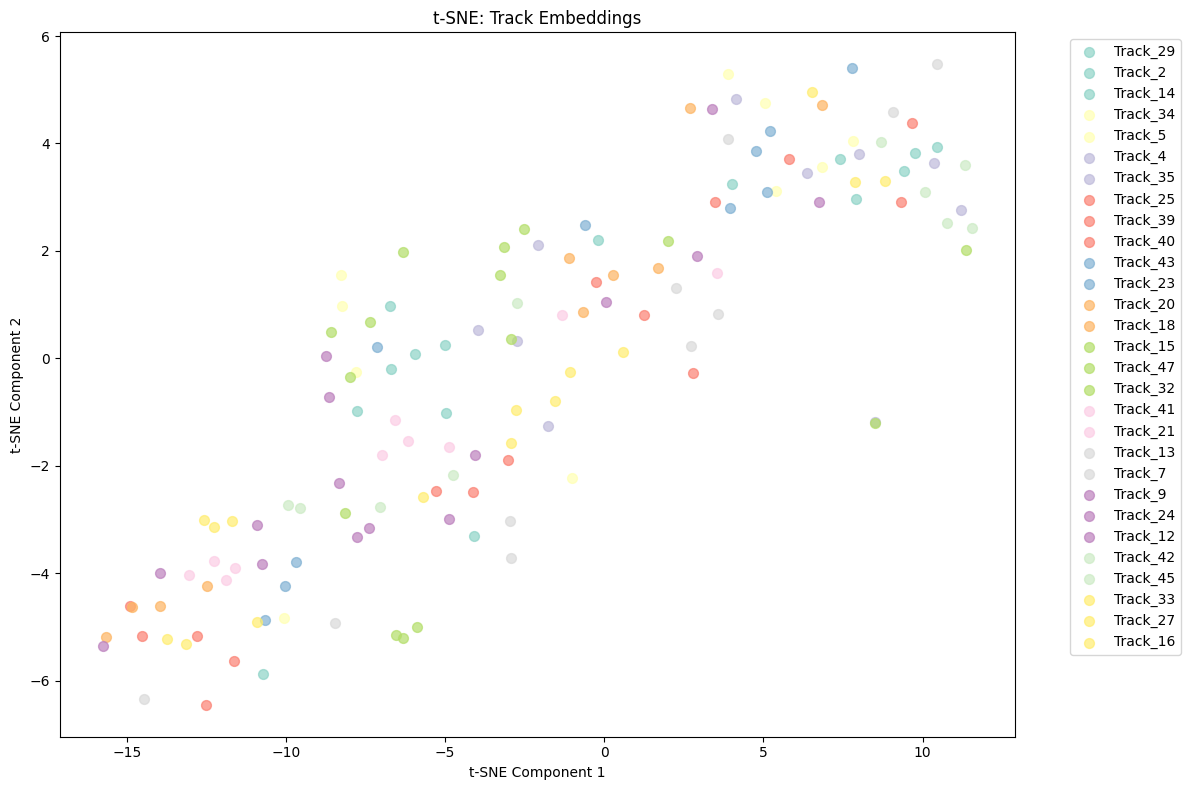

Running PCA on 145 embeddings...


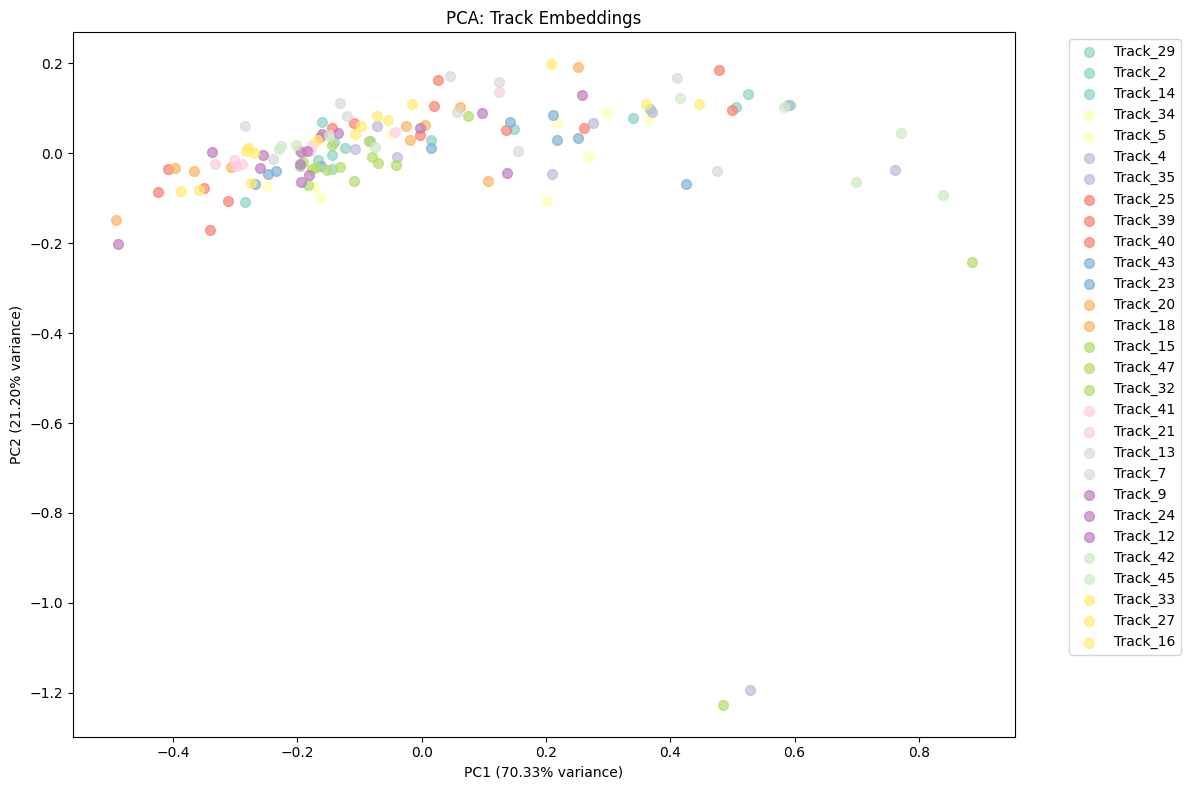

Total variance explained: 91.53%


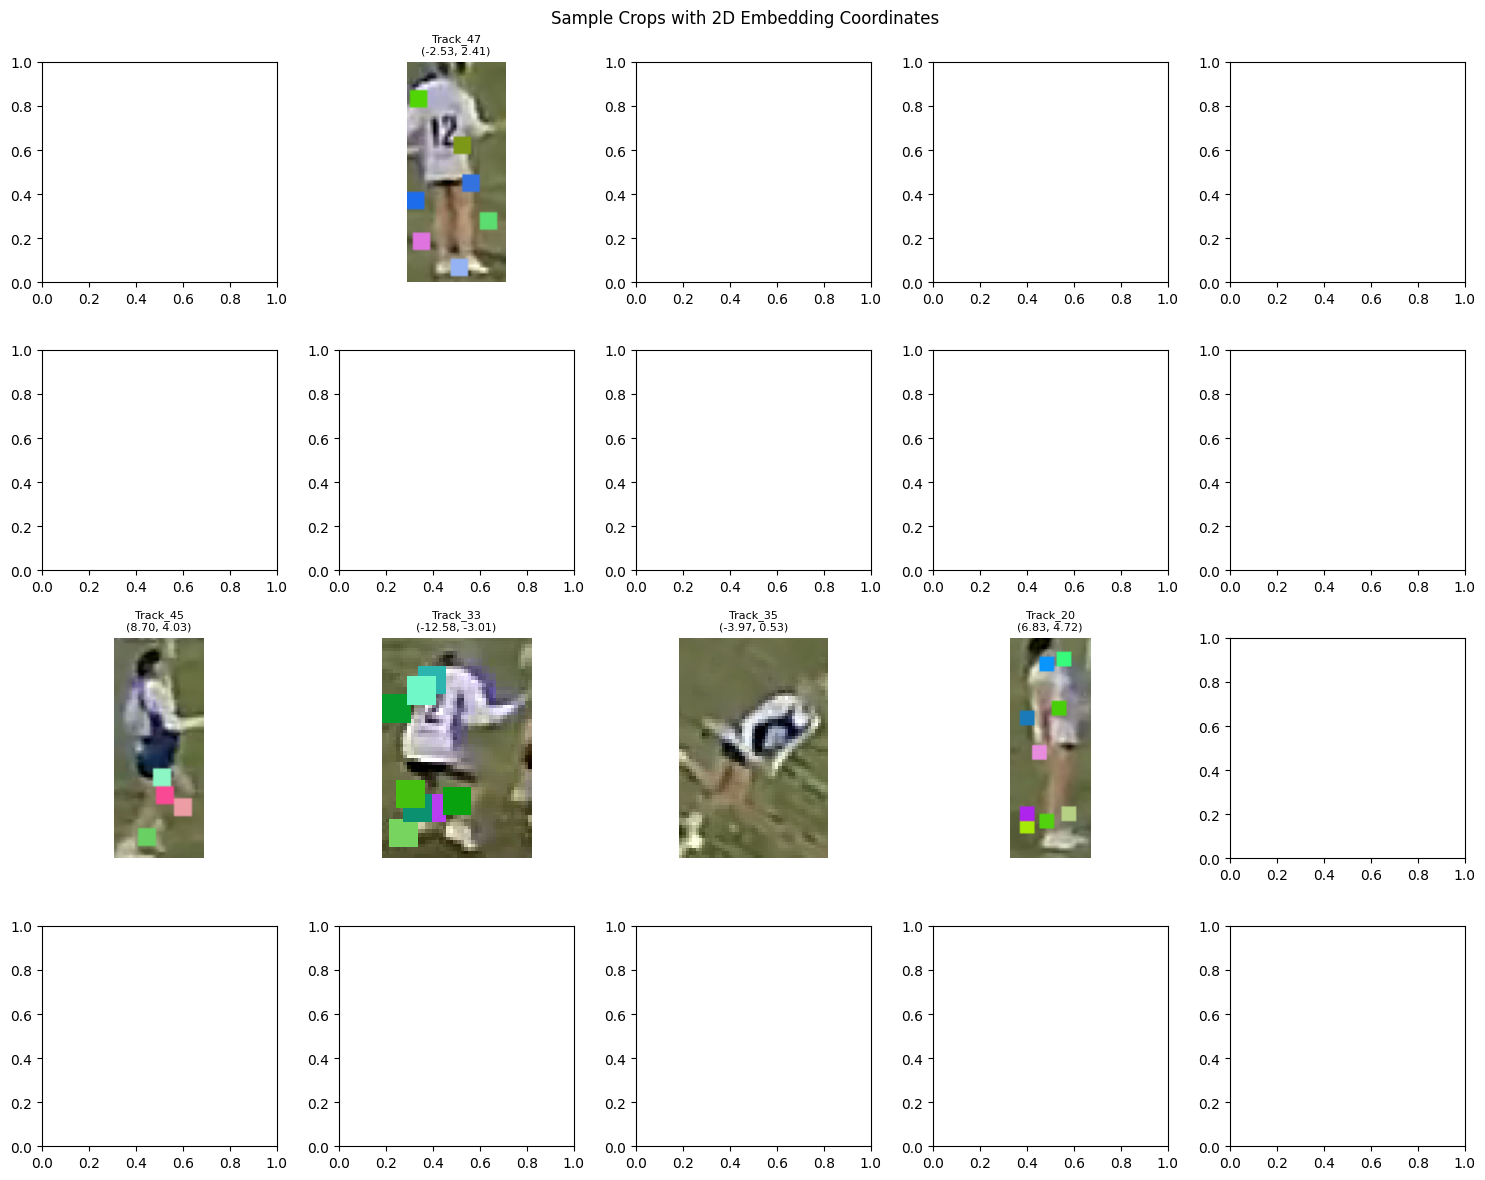

Embedding visualization complete!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from config.transforms import get_transforms

# Function to generate embeddings from crops
def generate_embeddings_from_crops(crops_dict, embeddings_processor, max_crops_per_track=10):
    """
    Generate embeddings for a subset of crops from each track.
    
    Args:
        crops_dict: Dictionary of {track_id: [crops]}
        embeddings_processor: Trained EmbeddingsProcessor instance
        max_crops_per_track: Maximum number of crops to process per track
    
    Returns:
        embeddings, labels, track_ids
    """
    all_embeddings = []
    all_labels = []
    all_track_ids = []
    
    transforms = get_transforms('opencv_safe')
    
    for track_id, crops in crops_dict.items():
        # Limit number of crops per track for visualization
        selected_crops = crops[:max_crops_per_track]
        
        if len(selected_crops) > 0:
            # Generate embeddings using the processor
            try:
                track_embeddings = embeddings_processor.create_embeddings_from_crops(
                    crops=selected_crops,
                    transform=transforms
                )
                
                # Convert to numpy if needed
                if hasattr(track_embeddings, 'cpu'):
                    track_embeddings = track_embeddings.cpu().numpy()
                
                all_embeddings.extend(track_embeddings)
                all_labels.extend([f"Track_{track_id}"] * len(track_embeddings))
                all_track_ids.extend([track_id] * len(track_embeddings))
                
            except Exception as e:
                print(f"Failed to generate embeddings for track {track_id}: {e}")
    
    return np.array(all_embeddings), all_labels, all_track_ids

# Function to visualize embeddings using t-SNE
def visualize_embeddings_tsne(embeddings, labels, title="t-SNE Visualization of Embeddings"):
    """Visualize embeddings using t-SNE dimensionality reduction."""
    print(f"Running t-SNE on {len(embeddings)} embeddings...")
    
    # Run t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(embeddings)-1))
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Get unique labels and assign colors
    unique_labels = list(set(labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = [l == label for l in labels]
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.7, s=50)
    
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d

# Function to visualize embeddings using PCA
def visualize_embeddings_pca(embeddings, labels, title="PCA Visualization of Embeddings"):
    """Visualize embeddings using PCA dimensionality reduction."""
    print(f"Running PCA on {len(embeddings)} embeddings...")
    
    # Run PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    
    # Get unique labels and assign colors
    unique_labels = list(set(labels))
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
    
    for i, label in enumerate(unique_labels):
        mask = [l == label for l in labels]
        plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                   c=[colors[i]], label=label, alpha=0.7, s=50)
    
    plt.title(title)
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2%}")
    return embeddings_2d, pca

# Function to show sample crops alongside embeddings
def visualize_crops_with_embeddings(crops_dict, embeddings_2d, labels, track_ids, max_display=20):
    """Display sample crops with their 2D embedding coordinates."""
    
    # Select random samples to display
    indices = np.random.choice(len(embeddings_2d), min(max_display, len(embeddings_2d)), replace=False)
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i >= len(axes):
            break
            
        track_id = track_ids[idx]
        # Find the corresponding crop (approximate - this is a simplified approach)
        crops = crops_dict.get(track_id, [])
        if crops:
            crop_idx = idx % len(crops)  # Simple mapping
            crop = crops[crop_idx]
            
            # Convert BGR to RGB for display
            crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(crop_rgb)
            axes[i].set_title(f"{labels[idx]}\n({embeddings_2d[idx, 0]:.2f}, {embeddings_2d[idx, 1]:.2f})", 
                            fontsize=8)
            axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle("Sample Crops with 2D Embedding Coordinates")
    plt.tight_layout()
    plt.show()

# Generate embeddings for visualization
print("Generating embeddings for visualization...")

# First, set up the trained model
test_processor = EmbeddingsProcessor(
    train_dir=temp_data_dir,
    model_save_path=model_save_path,
    device=device
)
test_processor.setup_model(SiameseNet, inference_only=True)

complete_embeddings = {}
for _ , augmented_crops_dict in enumerate(list_of_annotated_crops_dict):
    complete_embeddings.update(augmented_crops_dict)

# Generate embeddings
embeddings, labels, track_ids = generate_embeddings_from_crops(
    complete_embeddings, 
    test_processor, 
    max_crops_per_track=5  # Limit for faster visualization
)

print(f"Generated {len(embeddings)} embeddings from {len(set(track_ids))} tracks")

# Visualize using t-SNE
if len(embeddings) > 1:
    tsne_coords = visualize_embeddings_tsne(embeddings, labels, "t-SNE: Track Embeddings")
    
    # Visualize using PCA
    pca_coords, pca_model = visualize_embeddings_pca(embeddings, labels, "PCA: Track Embeddings")
    
    # Show sample crops with coordinates
    visualize_crops_with_embeddings(augmented_crops_dict, tsne_coords, labels, track_ids)
    
else:
    print("Not enough embeddings generated for visualization")

print("Embedding visualization complete!")

Setting up GradCAM analysis...
Generating GradCAM visualizations for all tracks...

Processing Track 15...


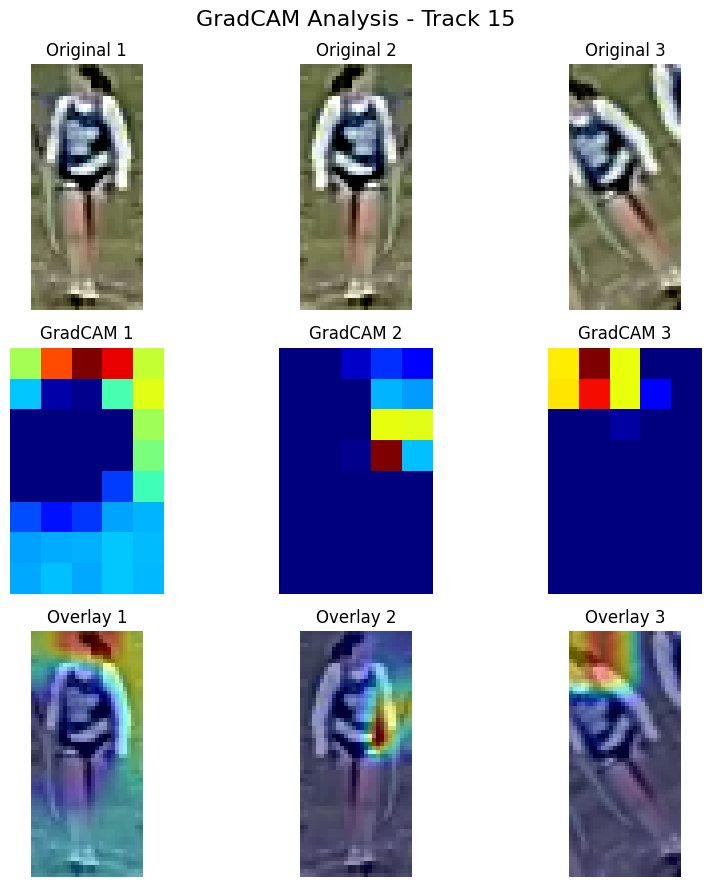


Processing Track 20...


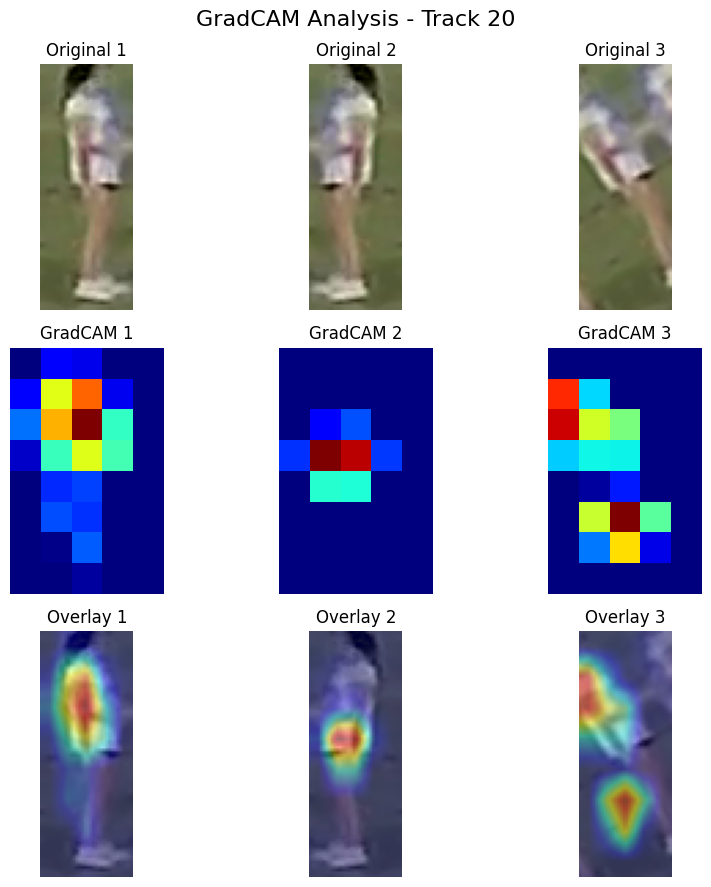


Processing Track 32...


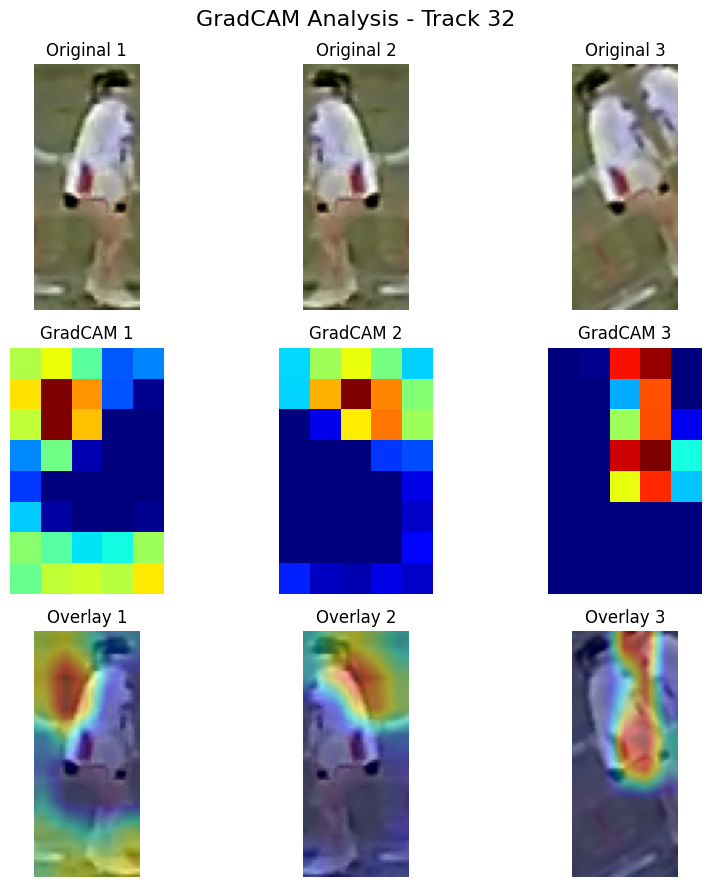


Processing Track 33...


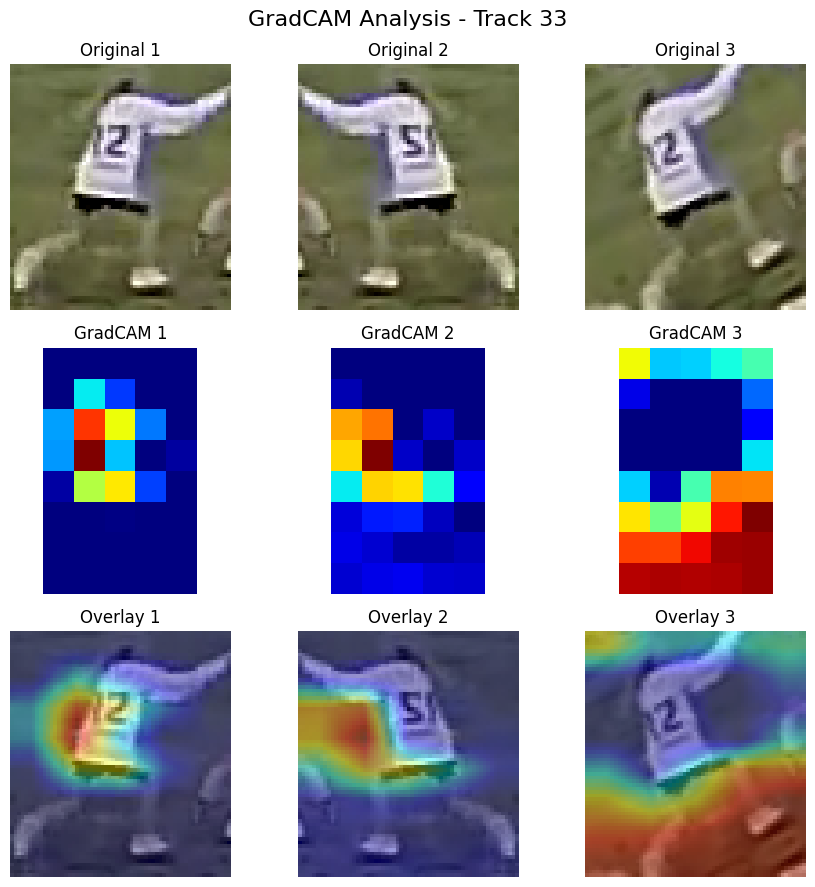


Processing Track 34...


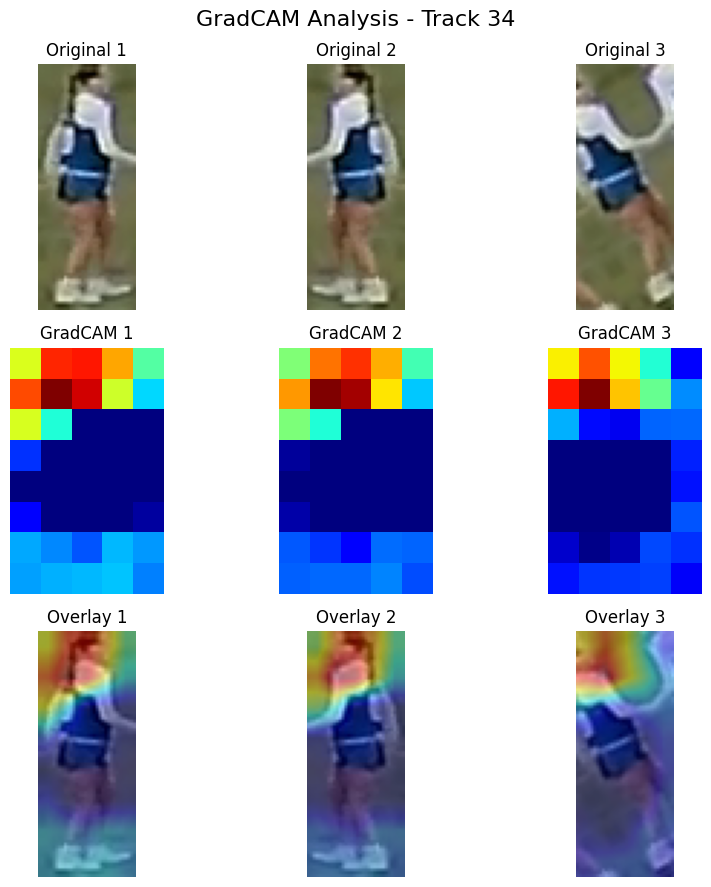


Processing Track 35...


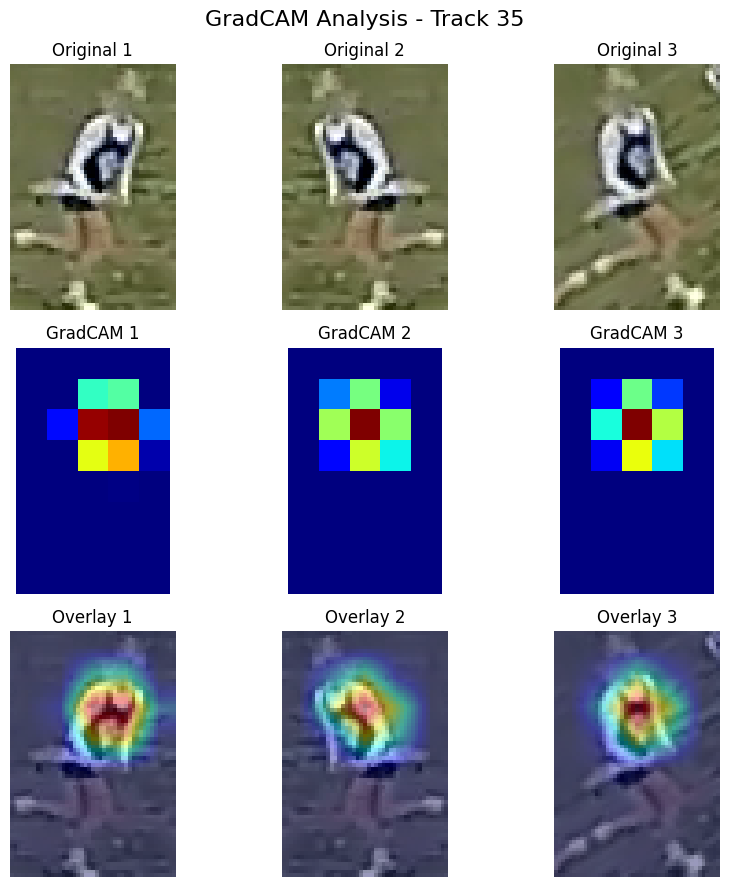


Processing Track 40...


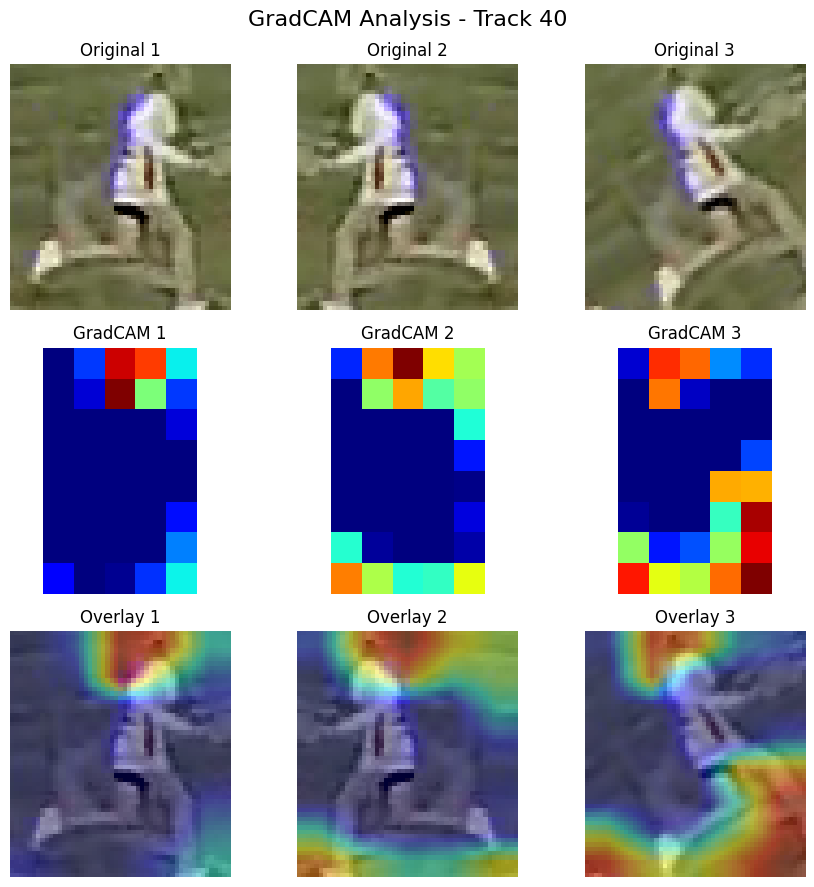


Processing Track 41...


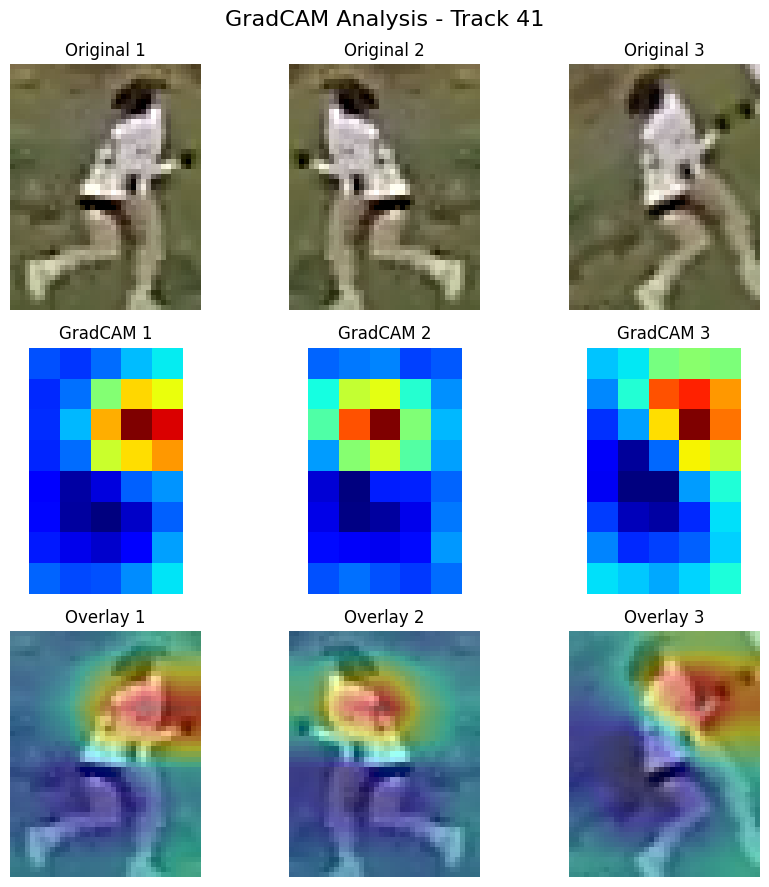


Processing Track 43...


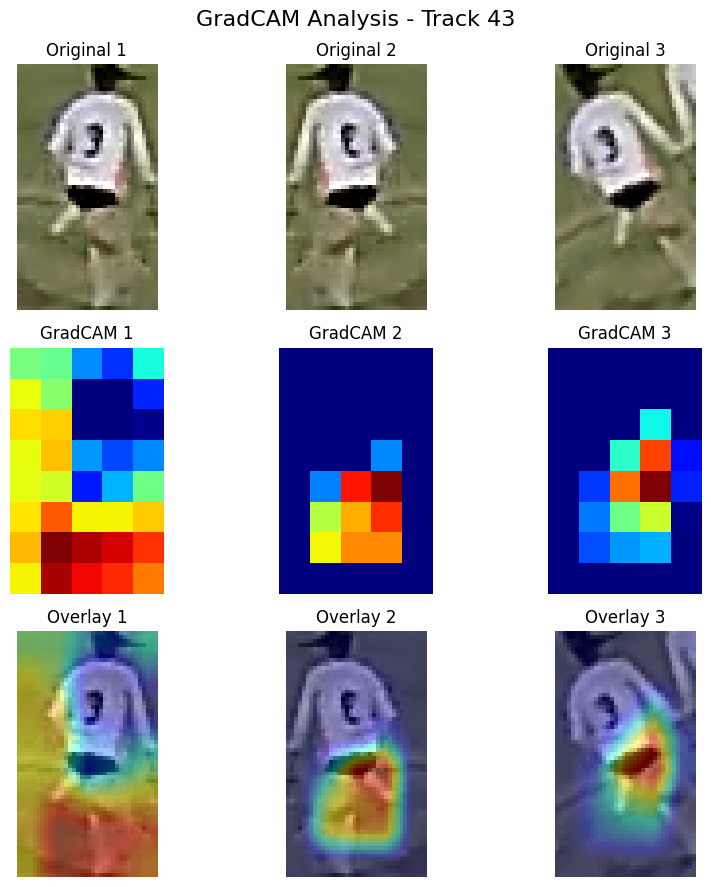


Processing Track 45...


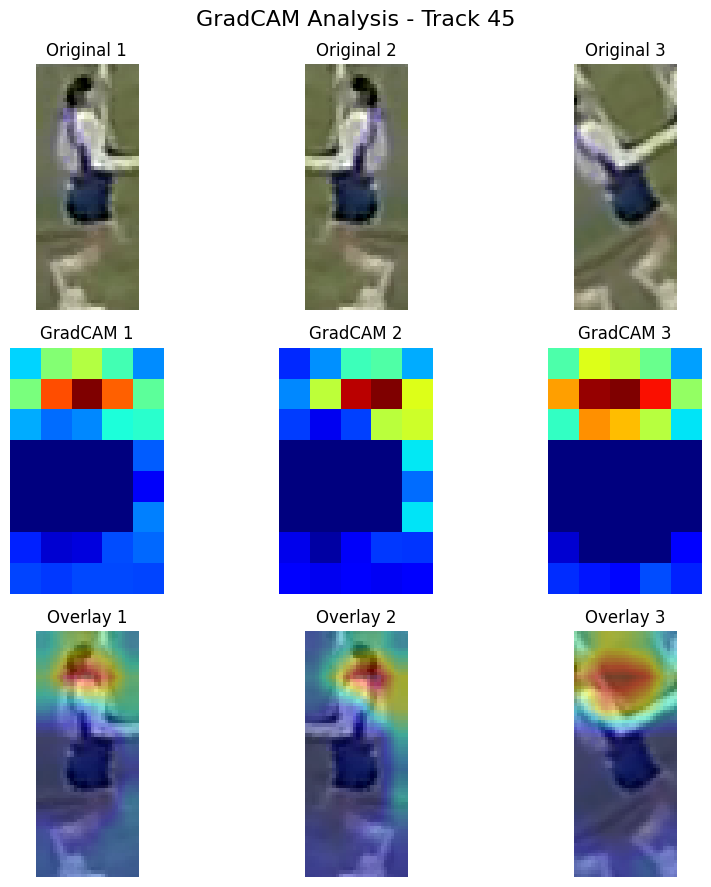


Processing Track 47...


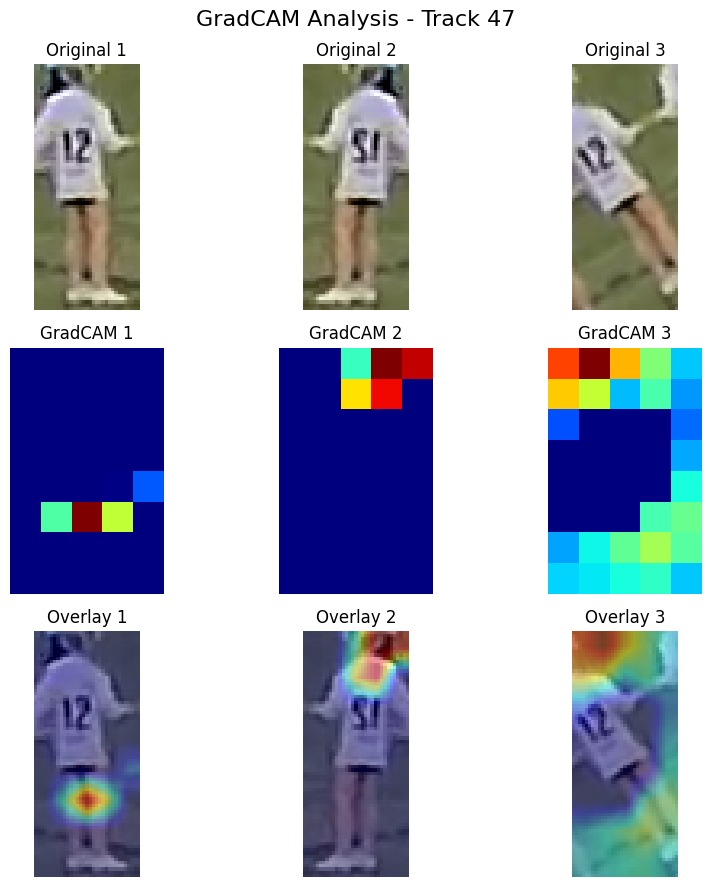

GradCAM analysis complete!


In [ ]:
import torch
import numpy as np
import cv2
from typing import List, Tuple
from config.transforms import get_transforms

import torch.nn.functional as F
import matplotlib.pyplot as plt

class GradCAM:
    def __init__(self, model, target_layer_name='backbone.layer4'):
        self.model = model
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self.register_hooks()
        
    def register_hooks(self):
        """Register forward and backward hooks on the target layer."""
        # Get the target layer
        target_layer = self.get_target_layer()
        
        # Register forward hook to capture activations
        target_layer.register_forward_hook(self.forward_hook)
        
        # Register backward hook to capture gradients
        target_layer.register_backward_hook(self.backward_hook)
    
    def get_target_layer(self):
        """Get the target layer from the model."""
        layer_names = self.target_layer_name.split('.')
        layer = self.model
        for name in layer_names:
            layer = getattr(layer, name)
        return layer
    
    def forward_hook(self, module, input, output):
        """Hook to capture forward activations."""
        self.activations = output
    
    def backward_hook(self, module, grad_input, grad_output):
        """Hook to capture gradients."""
        self.gradients = grad_output[0]
    
    def generate_cam(self, input_tensor, class_idx=None):
        """Generate CAM heatmap for given input."""
        # Forward pass
        self.model.eval()
        output = self.model(input_tensor)
        
        # If class_idx is None, use the predicted class
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        output[0, class_idx].backward()
        
        # Get gradients and activations
        gradients = self.gradients[0]  # Shape: [C, H, W]
        activations = self.activations[0]  # Shape: [C, H, W]
        
        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=(1, 2))  # Shape: [C]
        
        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32)  # Shape: [H, W]
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # Apply ReLU and normalize
        cam = F.relu(cam)
        cam = cam / torch.max(cam) if torch.max(cam) > 0 else cam
        
        return cam.detach().cpu().numpy()

def apply_gradcam_to_crops(model, crops, max_crops=5, target_layer='backbone.layer4'):
    """Apply GradCAM to a list of crops and return heatmaps."""
    if len(crops) == 0:
        return []
    
    # Initialize GradCAM
    gradcam = GradCAM(model, target_layer)
    
    # Get transforms for inference
    transforms = get_transforms('opencv_safe')
    
    heatmaps = []
    processed_crops = []
    
    # Process up to max_crops
    for i, crop in enumerate(crops[:max_crops]):
        if crop is None or crop.size == 0:
            continue
            
        try:
            # Convert BGR to RGB
            crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
            
            # Apply transforms
            input_tensor = transforms(crop_rgb).unsqueeze(0)  # Add batch dimension
            
            # Generate CAM
            cam = gradcam.generate_cam(input_tensor)
            
            heatmaps.append(cam)
            processed_crops.append(crop_rgb)
            
        except Exception as e:
            print(f"Error processing crop {i}: {e}")
            continue
    
    return heatmaps, processed_crops

def visualize_gradcam_results(crops, heatmaps, track_id, max_display=5):
    """Visualize original crops with GradCAM heatmaps."""
    if len(crops) == 0 or len(heatmaps) == 0:
        print(f"No valid crops/heatmaps for track {track_id}")
        return
    
    num_crops = min(len(crops), len(heatmaps), max_display)
    
    fig, axes = plt.subplots(3, num_crops, figsize=(3*num_crops, 9))
    if num_crops == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(num_crops):
        crop = crops[i]
        heatmap = heatmaps[i]
        
        # Original crop
        axes[0, i].imshow(crop)
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')
        
        # Heatmap
        axes[1, i].imshow(heatmap, cmap='jet')
        axes[1, i].set_title(f"GradCAM {i+1}")
        axes[1, i].axis('off')
        
        # Overlay
        # Resize heatmap to match crop size
        heatmap_resized = cv2.resize(heatmap, (crop.shape[1], crop.shape[0]))
        
        # Normalize heatmap for overlay
        heatmap_normalized = (heatmap_resized * 255).astype(np.uint8)
        heatmap_colored = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Create overlay
        overlay = cv2.addWeighted(crop, 0.6, heatmap_colored, 0.4, 0)
        
        axes[2, i].imshow(overlay)
        axes[2, i].set_title(f"Overlay {i+1}")
        axes[2, i].axis('off')
    
    plt.suptitle(f"GradCAM Analysis - Track {track_id}", fontsize=16)
    plt.tight_layout()
    plt.show()

def generate_gradcam_for_all_tracks(augmented_crops_dict, model, max_crops_per_track=3):
    """Generate GradCAM visualizations for all tracks."""
    print("Generating GradCAM visualizations for all tracks...")
    
    for track_id, crops in augmented_crops_dict.items():
        print(f"\nProcessing Track {track_id}...")
        
        # Apply GradCAM
        heatmaps, processed_crops = apply_gradcam_to_crops(
            model, crops, max_crops=max_crops_per_track
        )
        
        if len(heatmaps) > 0:
            # Visualize results
            visualize_gradcam_results(processed_crops, heatmaps, track_id, max_display=max_crops_per_track)
        else:
            print(f"No valid heatmaps generated for Track {track_id}")

# Apply GradCAM to our trained model and augmented crops
print("Setting up GradCAM analysis...")

# Make sure the model is in evaluation mode
test_processor.model.eval()

# Generate GradCAM for all tracks
generate_gradcam_for_all_tracks(augmented_crops_dict, test_processor.model, max_crops_per_track=3)

print("GradCAM analysis complete!")

In [ ]:
from config.transforms import get_global_background_detector
background_detector = get_global_background_detector()
if background_detector:
            # The detector's get_stats() method provides all relevant info
            stats = background_detector.get_stats()

            print("\nApplied Configuration:")
            print(f"  - HSV Lower Bound (The Range): {stats.get('lower_bound')}")
            print(f"  - HSV Upper Bound (The Range): {stats.get('upper_bound')}")
            print(f"  - Sensitivity (Std Dev Multiplier): {stats.get('std_dev_multiplier')}")
            print(f"  - Replacement Color (RGB): {stats.get('replacement_color')}")
            
else:
    # This state is unlikely if is_background_removal_enabled() is true,
    # but it is good practice to handle it.
    print("⚠️ Warning: Background removal is enabled, but detector is not available.")


Applied Configuration:
  - HSV Lower Bound (The Range): [81 84 59]
  - HSV Upper Bound (The Range): [ 89 179 121]
  - Sensitivity (Std Dev Multiplier): 1.0
  - Replacement Color (RGB): (255, 255, 255)
